# Harmonic oscillator physics-informed neural network (PINN)

This notebook was adapted from [Dr. Ben Moseley's notebook](https://github.com/benmoseley/harmonic-oscillator-pinn) to reproduce the plots presented in his blog post ["So, what is a physics-informed neural network?"](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/)


## 1. Setup

In [2]:
# Core libraries
import numpy as np

# PyTorch imports
import torch
import torch.nn as nn

# Plotting aesthetics
import matplotlib.pyplot as plt

## 2. Problem definition


The example problem we solve here is the damped harmonic oscillator.

> The damped harmonic oscillator is a classic problem in mechanics. It describes the movement of a mechanical oscillator (e.g., spring pendulum) under the influence of a restoring force and friction.

This problem was described in details in [this blog post](https://beltoforion.de/en/harmonic_oscillator/).

![Oscillator](https://benmoseley.blog/wp-content/uploads/2021/08/oscillator.gif)

The ODE for this system is as follows.

$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$$

$t$: time (s)

$x$: displacement from the equilibrium position (m)

$m$: mass (kg) (It determines the inertia of the system, i.e., how much it resists changes in motion.)

$\mu$: damping coefficient (kg/s) (It represents the strength of the damping force, which can arise from friction, air resistance, or any resistive force.)

$k$: spring constant / stiffness (N/m) (It characterizes the restoring force.)


We will focus on solving the problem for the under-damped state, i.e., oscillating before stopping. This requires a certain combination of the $m$, $\mu$, and $k$ parameters.

$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$

$\delta$: damping ratio (A normalized damping rate. Determines how fast the system loses energy).

$\omega_0$: natural frequency (Frequency the system would oscillate at without damping.)

For this problem, we use $\delta=2$, $\omega_0=20$, $m=1$, and try to learn the solution over the domain $x\in [0,1]$.

In [3]:
delta, omega0, m = 2, 20, 1

mu = 2 * m * delta
k  = m * omega0 ** 2

This problem has the following exact solution.
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$

In [4]:
def oscillator(delta, omega0, t):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem.
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""

    assert delta < omega0
    omega = np.sqrt(omega0 ** 2 - delta ** 2)

    phi = np.arctan(-delta / omega)
    A = 1 / (2 * np.cos(phi))
    exp = torch.exp(-delta * t)
    cos = torch.cos(phi + omega * t)
    x = exp * 2 * A * cos
    return x

torch.Size([500, 1]) torch.Size([500, 1])


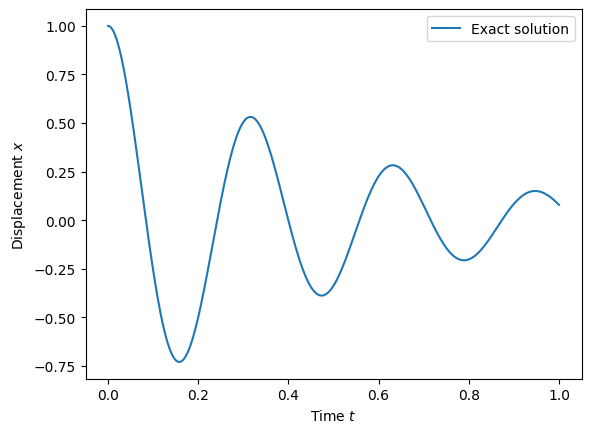

In [5]:
# get the analytical solution over the full domain
t = torch.linspace(0,1,500).view(-1,1)
x = oscillator(delta, omega0, t).view(-1,1)
print(t.shape, x.shape)

plt.figure()
plt.plot(t, x, label="Exact solution")
plt.xlabel("Time $t$")
plt.ylabel("Displacement $x$")
plt.legend()
plt.show()

We can try to use a numerical method, simulating x at each time step.

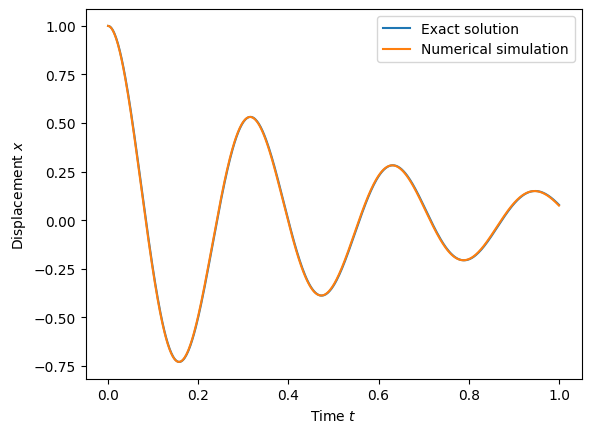

In [8]:
# Initial conditions
x_num = 1.0  # initial displacement for numerical simulation
v_num = 0.0  # initial velocity for numerical simulation
dt = 0.001  # time step # try a larger dt

# Store history for plotting
x_hist, t_hist = [x_num], [0]

# Simulation parameters
steps = int(1/dt)  # number of steps to take

# Run simulation
for i in range(steps):
    # Calculate spring force: F_spring = -k * x
    F_spring = -k * x_num

    # Calculate damping force: F_damping = -mu * v
    F_damping = -mu * v_num

    # Calculate net force: F = F_spring + F_damping
    F = F_spring + F_damping

    # Calculate acceleration: a = F / m
    a = F / m

    # Update velocity: v = v + a*dt
    v_num += a * dt

    # Update position: x = x + v*dt
    x_num += v_num * dt

    # Store for plotting
    x_hist.append(x_num)
    t_hist.append((i+1) * dt)

# Visualize the results
plt.figure()
plt.plot(t, x, label="Exact solution")
plt.plot(t_hist, x_hist, label="Numerical simulation")
plt.xlabel("Time $t$")
plt.ylabel("Displacement $x$")
plt.legend()
plt.show()

## 3. Data generation

We generate some training data from a small part of the true analytical solution. We will use them as "ground truth" later on.



torch.Size([10, 1]) torch.Size([10, 1])


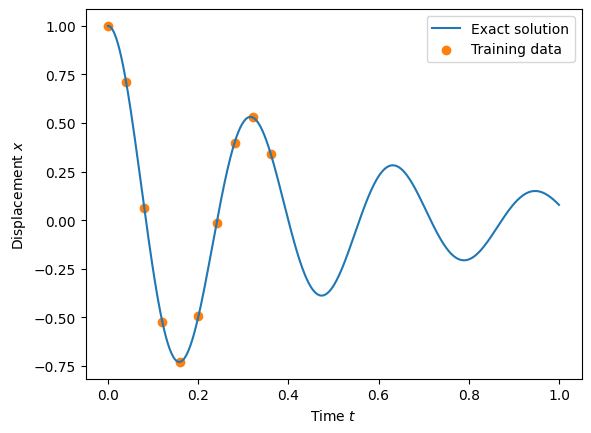

In [9]:
# slice out a small number of points from the exact solution in the domain
t_data = t[0:200:20]
x_data = x[0:200:20]
print(x_data.shape, t_data.shape)

plt.figure()
plt.plot(t, x, label="Exact solution")
plt.scatter(t_data, x_data, color="tab:orange", label="Training data")
plt.xlabel("Time $t$")
plt.ylabel("Displacement $x$")
plt.legend()
plt.show()

For this problem, we will need to generate two sets of training "data" to carry information in the ODE and initial condition, respectively. The locations for generating these training data are called __collocation points__.

Here we evaluate the physics loss at 30 points uniformly spaced over the problem domain $([0,1])$.

We also need a point at $t=0$ for initial condition.

In [10]:
torch.manual_seed(123)

# sample locations over the problem domain
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

# initial condition
t_0 = torch.tensor([[0.0]], requires_grad=True)

We do not explicitly calculate the corresponding target values at these collocation points. Targets for enforcing the ODE and initial conditions will be zero.

## 4. Neural Network

We define a connected network.

In [11]:
class Network(nn.Module):
    def __init__(self, n_input, n_output, n_hidden, n_layers):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(n_input, n_hidden),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(n_hidden, n_hidden),
                            activation()]) for _ in range(n_layers-1)])
        self.fce = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

## 5. PINN

We examine the ODE for this system.

$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$$

We need to calculate the derivatives of the network solution $x$ with respect to its input variable $t$ at collocation points using `pytorch`'s autodifferentiation features, and can then easily compute the residual of the differential equation using these quantities.

In [12]:
def derivative(output, input):
    df_t = torch.autograd.grad(output, input, grad_outputs=torch.ones_like(output), create_graph=True)[0]
    return df_t

The physics loss aims to ensure that the learned solution is consistent with the underlying differential equation. This is done by penalising the residual of the differential equation over collocation points.

The initial condition loss ensure that the solution and derivatives are consistent with known initial conditions.

> 💡 Exploration
>
> We have collocation points `t_physics`. We will later pass it through a NN called `model`.
>
> `x_pred_physics = model(t_physics)`
>
> We can use the `derivative` function to calculate first and second order derivatives of `x` at `t_physics`.
>
> `dx = derivative(x_pred_physics, t_physics)`
>
> `dx2 = derivative(dx, t_physics)`
>
> Now, can you use the three output above to calculate physics residuals?
>
> `physics = ?`

We write customized functions to calculate physics residuals and initial condition residuals.

In [13]:
def ODE(model, t_physics):
    x_pred_physics = model(t_physics)
    dx = derivative(x_pred_physics, t_physics)
    dx2 = derivative(dx, t_physics)

    physics = m * dx2 + mu * dx + k * x_pred_physics # computes the residual of the 1D harmonic oscillator differential equation

    return physics

def IC(model, t_0):
    x_pred_0 = model(t_0)
    dx0 = derivative(x_pred_0, t_0)

    ic1 = x_pred_0 - 1 # initial condition on x(0)
    ic2 = dx0 # initial condition on dx/dt

    return ic1, ic2

> 💡 Exploration
>
> Let's visualize how the physics residual calculating is working. Please set some altered parameters below to generate a "wrong" model, use our `ODE` function to calculate physics residuals, visualize them.

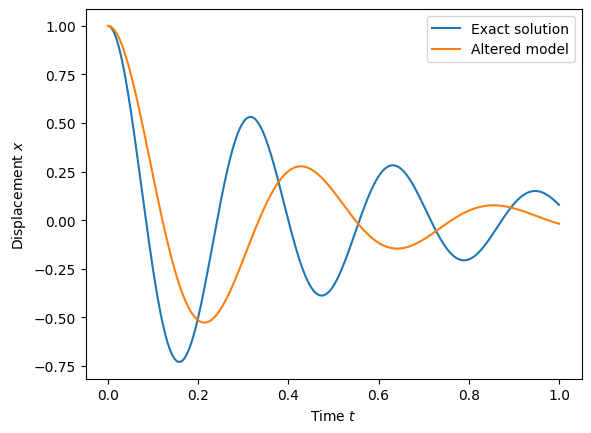

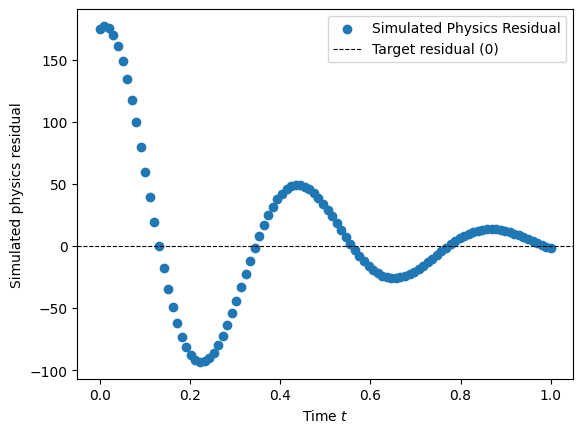

In [14]:
# Set altered parameters for visualization
delta_viz, omega0_viz, m_viz = delta + 1, omega0 - 5, m

mu_viz = 2 * m_viz * delta_viz
k_viz  = m_viz * omega0_viz ** 2

t = torch.linspace(0,1,500).view(-1,1)
x_viz = oscillator(delta_viz, omega0_viz, t).view(-1,1)

# Create a mock model for visualization
# In a real scenario, you would pass your trained model here
class MockModel(nn.Module):
    def forward(self, t):
        simulated_x = oscillator(delta_viz, omega0_viz, t)
        return simulated_x

mock_model = MockModel()

# Generate simulated physics data points
t_physics_viz = torch.linspace(0, 1, 100).view(-1, 1).requires_grad_(True)

# Calculate the simulated physics residual
simulated_physics_residual = ODE(mock_model, t_physics_viz)

# Visualize the simulated model output
plt.figure()
plt.plot(t, x, label="Exact solution")
plt.plot(t, x_viz, label="Altered model")
plt.xlabel("Time $t$")
plt.ylabel("Displacement $x$")
plt.legend()
plt.show()

# Visualize the simulated physics residual
plt.figure()
plt.scatter(t_physics_viz.detach().numpy(), simulated_physics_residual.detach().numpy(), label="Simulated Physics Residual")
plt.axhline(0, color='k', linestyle='--', linewidth=0.8, label="Target residual (0)")
plt.xlabel("Time $t$")
plt.ylabel("Simulated physics residual")
plt.legend()
plt.show()

We write a PINN wrapper to collect the physics residuals, initial condition residuals, and data residuals with weighting.

In [15]:
# PINN Wrapper
class PINNWrapper:
    def __init__(self, model):
        self.model = model

    def forward(self, t_physics, t_0, t_data, x_data):
        # ODE loss
        physics = ODE(self.model, t_physics)
        loss_physics = (1e-4)*torch.mean(physics**2)

        # IC loss
        ic1, ic2 = IC(self.model, t_0)
        loss_ic1 = torch.mean(ic1**2)
        loss_ic2 = torch.mean(ic2**2)
        loss_ic = (1e-4)*(loss_ic1 + loss_ic2)

        # Data loss
        x_pred_data = self.model(t_data)
        loss_data = torch.mean((x_pred_data-x_data)**2)

        return loss_physics, loss_ic, loss_data

## 6. Training and prediction

We write a training loop to optimize model weights using loss terms in the specified number of epochs. We visualize predictions as we train the model.

In [16]:
# Training loop
def train(model_wrapper, optimizer, t_physics, t_0, t_data, x_data, epochs=15000):

    model = model_wrapper.model
    model.train()

    epoch = 0
    for epoch in range(epochs):
        loss_physics, loss_ic, loss_data = model_wrapper.forward(
            t_physics, t_0, t_data, x_data
        )

        loss = loss_physics + loss_ic + loss_data

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # plot the result as training progresses
        if (epoch+1) % 5000 == 0:

            x_pred = model(t)
            plot_result(t,x,t_data,x_data,x_pred,t_physics, epoch)
            plt.show()

In [17]:
def plot_result(t,x,t_data,x_data,x_pred,t_physics=None, epoch=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(t.detach(),x.detach(), color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(t.detach(),x_pred.detach(), color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(t_data.detach(), x_data.detach(), s=60, color="tab:orange", alpha=0.4, label='Training data')
    if t_physics is not None:
        plt.scatter(t_physics.detach(), -0*torch.ones_like(t_physics.detach()), s=60, color="tab:green", alpha=0.4,
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %d"%(epoch+1),fontsize="xx-large",color="k")
    plt.axis("off")

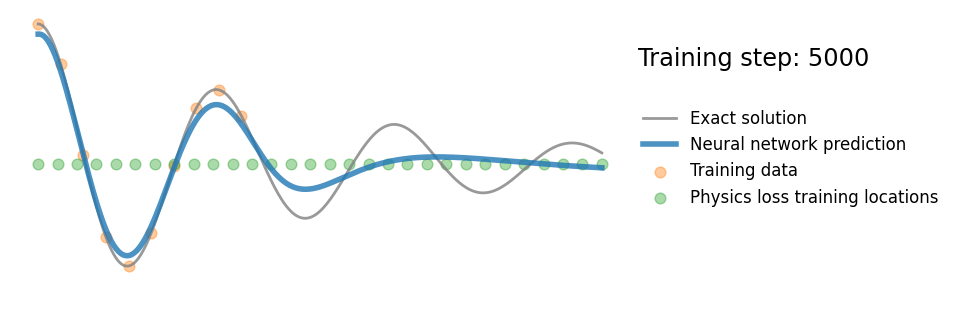

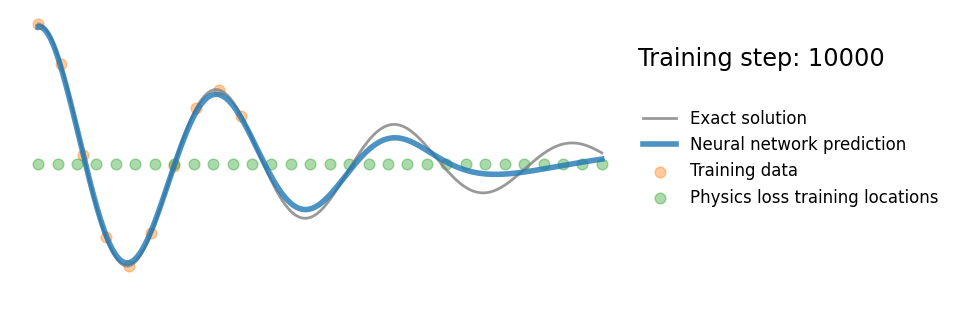

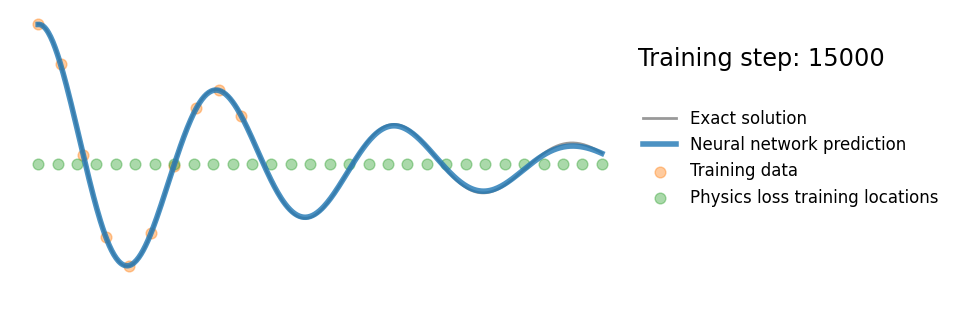

In [18]:
torch.manual_seed(123)
network = Network(n_input = 1, n_output = 1, n_hidden = 32, n_layers = 3)
pinn_wrapper = PINNWrapper(network)
optimizer = torch.optim.Adam(params = network.parameters(), lr = 1e-4)
train(pinn_wrapper, optimizer, t_physics, t_0, t_data, x_data, epochs=15000)

> 💡 Exploration
>
> Please alter the number of hidden layers or the number of neurons in each hidden layer in `Network`, learning rate `lr` in `torch.optim.Adam`, or number of epochs in `train`, to see the outcome of training.

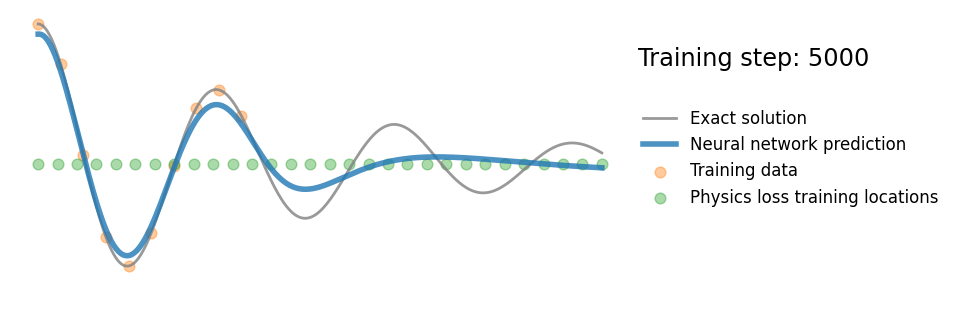

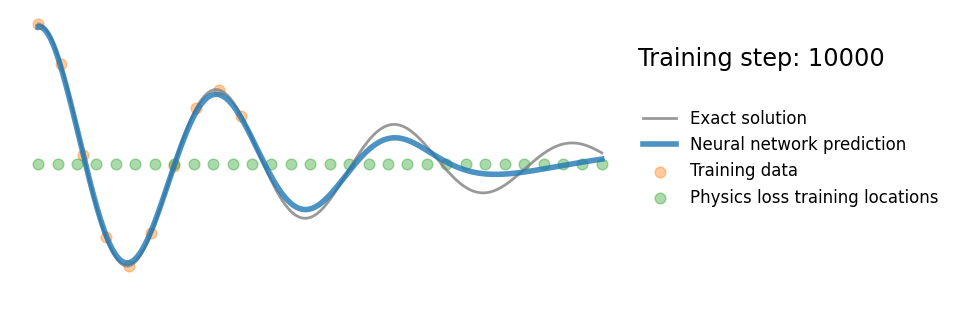

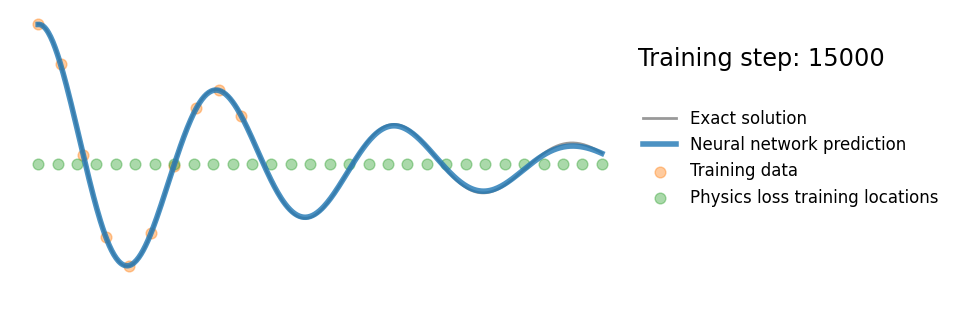

In [ ]:
torch.manual_seed(123)
network = Network(n_input = 1, n_output = 1, n_hidden = 32, n_layers = 3)
pinn_wrapper = PINNWrapper(network)
optimizer = torch.optim.Adam(params = network.parameters(), lr = 1e-4)
train(pinn_wrapper, optimizer, t_physics, t_0, t_data, x_data, epochs=15000)

## 7. Comparison with standard neural network

We train a standard neural network (fully connected network) to fit the ground truth.

Run this optionally for comparison.

In [19]:
# Training loop
def train_nn(model, optimizer, t_data, x_data, epochs=15000):

    model.train()

    for epoch in range(epochs):

        optimizer.zero_grad()
        x_pred = model(t_data)
        loss = torch.mean((x_pred-x_data)**2)# use mean squared error
        loss.backward()
        optimizer.step()

        # plot the result as training progresses
        if (epoch+1) % 5000 == 0:

            x_pred = model(t)
            plot_result(t,x,t_data,x_data,x_pred,t_physics=None, epoch=epoch)
            plt.show()

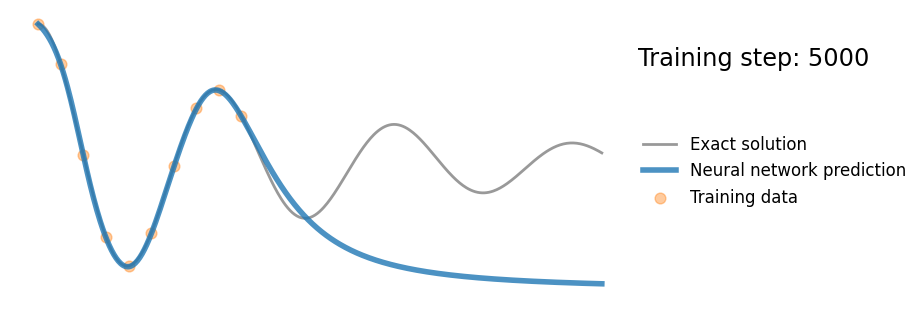

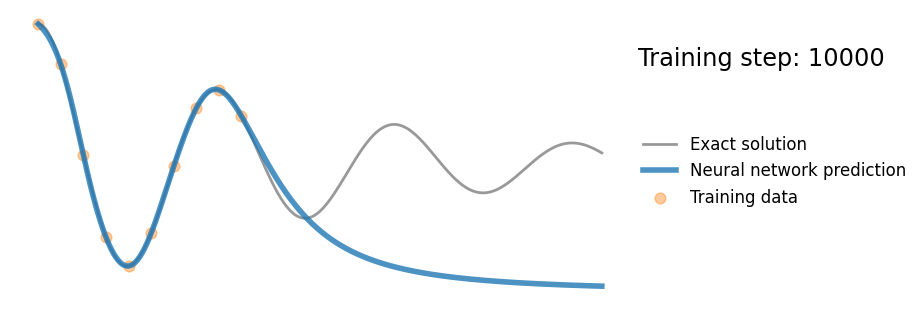

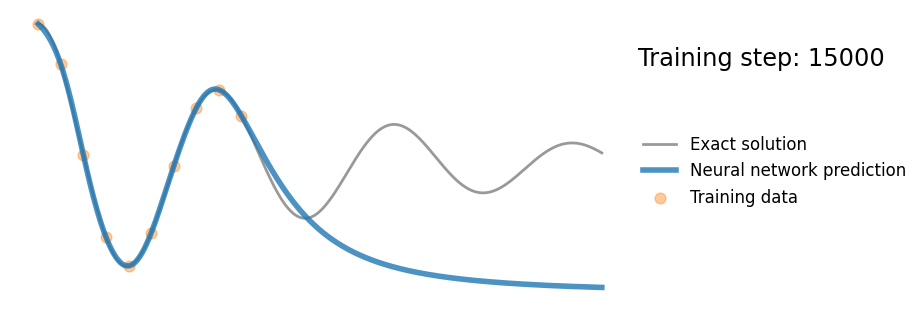

In [20]:
# train standard neural network to fit training data
torch.manual_seed(123)
network = Network(1,1,32,3)
optimizer = torch.optim.Adam(params = network.parameters(), lr = 1e-3)
train_nn(network, optimizer, t_data, x_data, epochs=15000)

We find that the network is able to fit the solution very closely in the vicinity of the training points, but does not learn an accurate solution outside of them.